In [1]:
import sys
import polars as pl
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# adding Folder_2 to the system path
sys.path.insert(0, '../Python')

from helper_add_ep_wp import add_ep_variables
from helper_add_hudl_mutations import make_hudl_mutations, prepare_ep_data
from helper_add_model_mutations import make_ep_model_mutations

In [2]:
import pickle

# load model
xgb_model_ep_loaded = pickle.load(open("../models/ep_model.pkl", "rb"))
# xgb_model_ep_loaded = pickle.load(open("../models/ep_model_simple.pkl", "rb"))

In [3]:
# adding Folder_2 to the system path
sys.path.insert(0, '../Python')
from helper_add_ep_wp import add_ep_variables, add_wp_variables
from helper_add_model_mutations import make_ep_model_mutations, make_wp_model_mutations
from helper_add_hudl_mutations import make_hudl_mutations, make_dsfootball_mutations, prepare_ep_data, prepare_wp_data
df = pl.read_csv("../data_raw.csv",separator=";",infer_schema_length=0)
df1 = make_hudl_mutations(df)
df1 = prepare_wp_data(df1)
df2 = prepare_ep_data(df1)
features_ep = [
    # "half_seconds_remaining",
    "yardline_50",
    # "yardline_50_simple",
    "yards_to_go",
    # "yards_to_go_simple",
    "down0", "down1", "down2", "down3", "down4",
    ]
spain_data = df2.filter(pl.col("game_id") == 35)
spain_epa = make_ep_model_mutations(spain_data, features_ep).drop("label")


In [4]:
# Spaltenauswahl
selected_columns = [
    "label",
    # "half_seconds_remaining",
    "yardline_50",
    # "yardline_50_simple",
    "yards_to_go",
    # "yards_to_go_simple",
    "down0", "down1", "down2", "down3", "down4",
    "Total_W_Scaled",
]

In [6]:
model_data = df2.filter(pl.col("game_id") != 37)
model_data = make_ep_model_mutations(model_data, selected_columns)
model_data = model_data.drop_nulls()

X= model_data.select(features_ep)
y = model_data.select("label")
weight_X, weight_y = train_test_split(model_data.select("Total_W_Scaled"),test_size = 0.2, random_state = 42)
train_X, test_X, train_y, test_y = train_test_split(X, y,test_size = 0.2, random_state = 42)

In [7]:
import shap
shap.initjs()

c:\Users\Templer\OneDrive\Dokumente\flag_epa\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
X_sub = shap.sample(train_X.to_pandas(), 100)
pred_spain = xgb_model_ep_loaded.predict(spain_epa.to_numpy())
explainer = shap.TreeExplainer(xgb_model_ep_loaded, spain_epa.to_pandas())
shap_values = explainer(spain_epa.to_pandas().iloc[0:100])

In [10]:
class_index = 1
data_index = 0

spain_epa.head(2)

yardline_50,yards_to_go,down0,down1,down2,down3,down4
i32,i32,i32,i32,i32,i32,i32
5,20,0,1,0,0,0
31,19,0,1,0,0,0


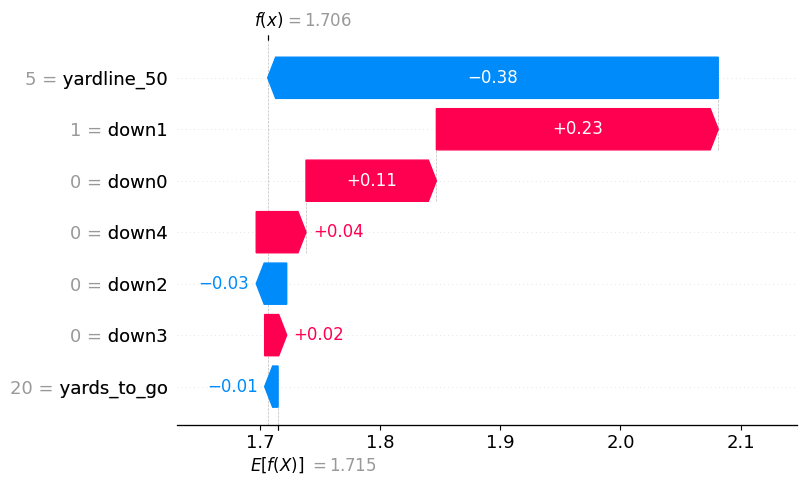

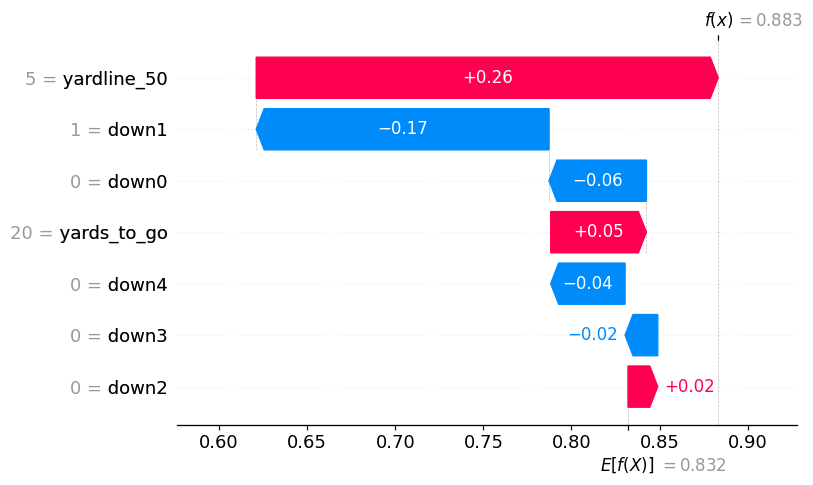

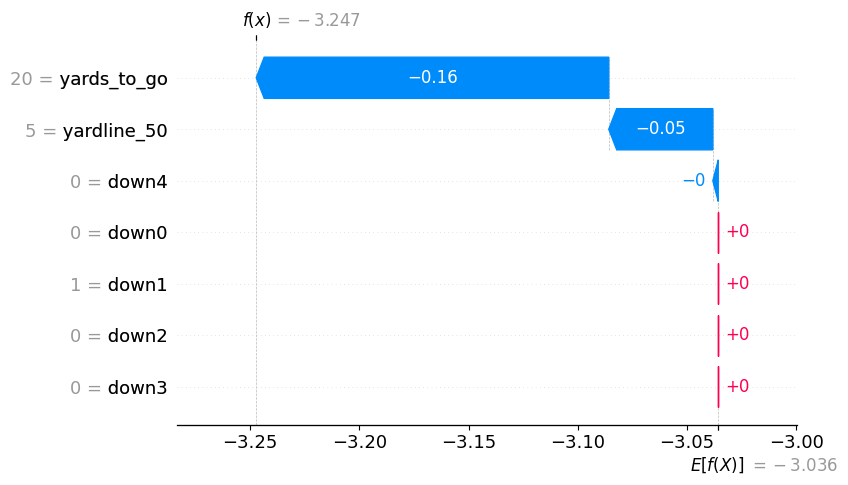

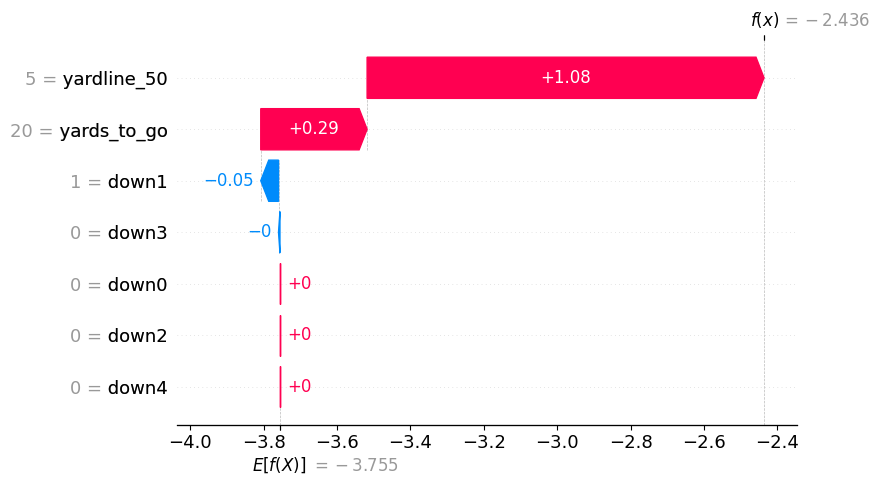

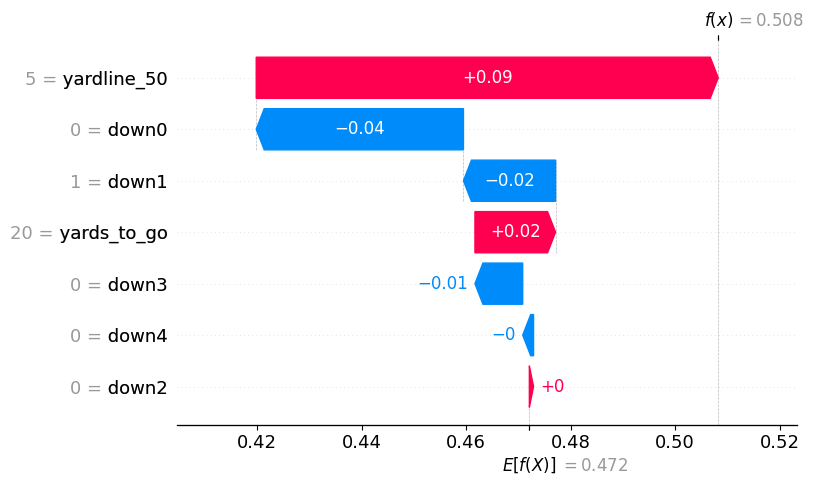

In [11]:
# waterfall plot for class 0
shap.plots.waterfall(shap_values[0,:,0])

# waterfall plot for class 1
shap.plots.waterfall(shap_values[0,:,1])

# waterfall plot for class 2
shap.plots.waterfall(shap_values[0,:,2])

# waterfall plot for class 3
shap.plots.waterfall(shap_values[0,:,3])

# waterfall plot for class 4
shap.plots.waterfall(shap_values[0,:,4])